# Random Forest Classification: A Complete Guide

Welcome to your comprehensive guide to **Random Forest classification**! This notebook will teach you about one of the most powerful and popular ensemble learning algorithms.

## What You'll Learn
1. **Ensemble Learning Concept**: Why multiple models are better than one
2. **Random Forest Algorithm**: How it builds multiple decision trees
3. **Bootstrap Sampling**: Creating diverse training sets
4. **Feature Randomness**: Why we don't use all features at each split
5. **Voting Mechanism**: How predictions are combined
6. **Bias-Variance Tradeoff**: Understanding overfitting reduction
7. **Feature Importance**: Measuring variable significance
8. **Practical Implementation**: Real-world applications and tuning

---

## 1. The Wisdom of Crowds: Why Ensembles Work

### Real-World Analogy: Guessing Jelly Beans

Imagine a jar with 1000 jelly beans. If you ask:

**One Expert**: Might guess 750 (could be way off)

**100 Random People**: 
- Person 1: 890
- Person 2: 1100
- Person 3: 950
- ...
- **Average of all guesses**: Often very close to 1000!

This is the **wisdom of crowds** - individual errors cancel out when you average many independent estimates.

### Machine Learning Analogy

**Single Decision Tree**: 
- Might overfit to specific patterns in training data
- Sensitive to small changes in data
- Can create overly complex rules

**Random Forest (Many Trees)**:
- Each tree sees slightly different data
- Each tree makes different mistakes
- **Average prediction** is more robust and accurate

### Key Insight

🌳 + 🌳 + 🌳 + ... + 🌳 = 🌲 (A stronger forest!)

**Individual trees are weak and prone to overfitting, but together they create a strong, generalizable model.**

In [1]:
# Setup and imports
import sys
import os
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import make_classification, load_iris
from utils.data_utils import load_titanic_data
from utils.evaluation import ModelEvaluator
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("[START] Random Forest Classification Tutorial")
print("All libraries loaded successfully!")

Using device: cuda
[START] Random Forest Classification Tutorial
All libraries loaded successfully!


## 2. How Random Forest Works: Step-by-Step

Random Forest combines two key randomization techniques:

### Step 1: Bootstrap Sampling (Bagging)

For each tree, create a **bootstrap sample**:
- Randomly sample N observations **with replacement** from the original training set
- Each tree sees a slightly different dataset
- About 63% of original samples appear in each bootstrap sample
- About 37% are "out-of-bag" (OOB) samples

### Step 2: Feature Randomness

At each split in each tree:
- Instead of considering all features, randomly select a subset
- Typical choices: √(total_features) or log₂(total_features)
- Find the best split among only these randomly selected features

### Step 3: Build Multiple Trees

- Build many decision trees (typically 100-1000)
- Each tree is trained on different data with different feature subsets
- Trees are typically grown deep (high variance, low bias)

### Step 4: Combine Predictions

**For Classification**:
- Each tree votes for a class
- Final prediction = majority vote
- Confidence = percentage of trees voting for winning class

**For Regression**:
- Each tree predicts a value
- Final prediction = average of all predictions

In [2]:
# Demonstrate bootstrap sampling
print("=== BOOTSTRAP SAMPLING DEMONSTRATION ===")
print()

# Create a small dataset to show bootstrap sampling
np.random.seed(42)
original_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
n_samples = len(original_data)

print(f"Original dataset: {original_data}")
print(f"Dataset size: {n_samples}")
print()

# Generate several bootstrap samples
n_bootstrap_samples = 5
bootstrap_samples = []
oob_samples = []

for i in range(n_bootstrap_samples):
    # Bootstrap sampling with replacement
    bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
    bootstrap_sample = original_data[bootstrap_indices]
    
    # Out-of-bag samples (not selected)
    oob_indices = np.setdiff1d(range(n_samples), np.unique(bootstrap_indices))
    oob_sample = original_data[oob_indices]
    
    bootstrap_samples.append(bootstrap_sample)
    oob_samples.append(oob_sample)
    
    print(f"Bootstrap Sample {i+1}: {bootstrap_sample}")
    print(f"  Unique values: {np.unique(bootstrap_sample)} ({len(np.unique(bootstrap_sample))}/{n_samples})")
    print(f"  Out-of-bag:   {oob_sample} ({len(oob_sample)}/{n_samples})")
    print(f"  OOB percentage: {len(oob_sample)/n_samples*100:.1f}%")
    print()

# Calculate average OOB percentage
avg_oob_pct = np.mean([len(oob)/n_samples*100 for oob in oob_samples])
print(f"Average Out-of-Bag percentage: {avg_oob_pct:.1f}%")
print(f"Theoretical expectation: ~37%")
print()
print("Key Insight: Each tree sees different data, making them diverse!")

=== BOOTSTRAP SAMPLING DEMONSTRATION ===

Original dataset: [ 1  2  3  4  5  6  7  8  9 10]
Dataset size: 10

Bootstrap Sample 1: [ 7  4  8  5  7 10  3  7  8  5]
  Unique values: [ 3  4  5  7  8 10] (6/10)
  Out-of-bag:   [1 2 6 9] (4/10)
  OOB percentage: 40.0%

Bootstrap Sample 2: [4 8 8 3 6 5 2 8 6 2]
  Unique values: [2 3 4 5 6 8] (6/10)
  Out-of-bag:   [ 1  7  9 10] (4/10)
  OOB percentage: 40.0%

Bootstrap Sample 3: [ 5  1 10  6  9  1 10  3  7  4]
  Unique values: [ 1  3  4  5  6  7  9 10] (8/10)
  Out-of-bag:   [2 8] (2/10)
  OOB percentage: 20.0%

Bootstrap Sample 4: [9 3 5 3 7 5 9 7 2 4]
  Unique values: [2 3 4 5 7 9] (6/10)
  Out-of-bag:   [ 1  6  8 10] (4/10)
  OOB percentage: 40.0%

Bootstrap Sample 5: [ 9  2 10  9 10  5  2  4  7  8]
  Unique values: [ 2  4  5  7  8  9 10] (7/10)
  Out-of-bag:   [1 3 6] (3/10)
  OOB percentage: 30.0%

Average Out-of-Bag percentage: 34.0%
Theoretical expectation: ~37%

Key Insight: Each tree sees different data, making them diverse!


In [3]:
# Demonstrate feature randomness
print("=== FEATURE RANDOMNESS DEMONSTRATION ===")
print()

# Load a dataset with multiple features
X_train, X_test, y_train, y_test, feature_names = load_titanic_data()
n_features = len(feature_names)

print(f"Dataset features ({n_features} total): {feature_names}")
print()

# Show feature subsets for different nodes
n_examples = 5
max_features_sqrt = int(np.sqrt(n_features))
max_features_log = int(np.log2(n_features))

print(f"Typical max_features choices:")
print(f"  sqrt({n_features}) = {max_features_sqrt}")
print(f"  log2({n_features}) = {max_features_log}")
print()

print(f"Example feature subsets (using sqrt = {max_features_sqrt} features):")
np.random.seed(42)
for i in range(n_examples):
    selected_indices = np.random.choice(n_features, size=max_features_sqrt, replace=False)
    selected_features = [feature_names[idx] for idx in selected_indices]
    print(f"  Node {i+1}: {selected_features}")

print()
print("Key Insight: Each split considers only a random subset of features,")
print("reducing correlation between trees and preventing overfitting!")

=== FEATURE RANDOMNESS DEMONSTRATION ===

Dataset features (8 total): ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Title']

Typical max_features choices:
  sqrt(8) = 2
  log2(8) = 3

Example feature subsets (using sqrt = 2 features):
  Node 1: ['Sex', 'FamilySize']
  Node 2: ['Fare', 'Title']
  Node 3: ['Pclass', 'IsAlone']
  Node 4: ['FamilySize', 'Age']
  Node 5: ['Sex', 'Title']

Key Insight: Each split considers only a random subset of features,
reducing correlation between trees and preventing overfitting!


In [4]:
# Compare single tree vs random forest
print("=== SINGLE TREE vs RANDOM FOREST COMPARISON ===")
print()

# Create models
single_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    random_state=42
)

# Train models
single_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

# Make predictions
tree_train_pred = single_tree.predict(X_train)
tree_test_pred = single_tree.predict(X_test)
rf_train_pred = random_forest.predict(X_train)
rf_test_pred = random_forest.predict(X_test)

# Calculate accuracies
tree_train_acc = accuracy_score(y_train, tree_train_pred)
tree_test_acc = accuracy_score(y_test, tree_test_pred)
rf_train_acc = accuracy_score(y_train, rf_train_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

print("Performance Comparison:")
print(f"Single Decision Tree:")
print(f"  Training Accuracy: {tree_train_acc:.3f}")
print(f"  Test Accuracy:     {tree_test_acc:.3f}")
print(f"  Overfitting Gap:   {tree_train_acc - tree_test_acc:.3f}")
print()
print(f"Random Forest:")
print(f"  Training Accuracy: {rf_train_acc:.3f}")
print(f"  Test Accuracy:     {rf_test_acc:.3f}")
print(f"  Overfitting Gap:   {rf_train_acc - rf_test_acc:.3f}")
print()
print(f"Improvement in test accuracy: {rf_test_acc - tree_test_acc:+.3f}")
print(f"Reduction in overfitting: {(tree_train_acc - tree_test_acc) - (rf_train_acc - rf_test_acc):+.3f}")

# Cross-validation for more robust comparison
tree_cv_scores = cross_val_score(single_tree, X_train, y_train, cv=5)
rf_cv_scores = cross_val_score(random_forest, X_train, y_train, cv=5)

print()
print("Cross-Validation Results (5-fold):")
print(f"Single Tree: {tree_cv_scores.mean():.3f} (+/- {tree_cv_scores.std() * 2:.3f})")
print(f"Random Forest: {rf_cv_scores.mean():.3f} (+/- {rf_cv_scores.std() * 2:.3f})")

=== SINGLE TREE vs RANDOM FOREST COMPARISON ===

Performance Comparison:
Single Decision Tree:
  Training Accuracy: 0.983
  Test Accuracy:     0.804
  Overfitting Gap:   0.179

Random Forest:
  Training Accuracy: 0.983
  Test Accuracy:     0.827
  Overfitting Gap:   0.156

Improvement in test accuracy: +0.022
Reduction in overfitting: +0.022

Cross-Validation Results (5-fold):
Single Tree: 0.759 (+/- 0.068)
Random Forest: 0.795 (+/- 0.091)


## 3. The Bias-Variance Tradeoff

Understanding why Random Forest works requires understanding the **bias-variance tradeoff**:

### Single Decision Tree:
- **Low Bias**: Can fit complex patterns
- **High Variance**: Small changes in data → very different trees
- **Result**: Often overfits

### Random Forest:
- **Low Bias**: Still fits complex patterns (deep trees)
- **Reduced Variance**: Averaging reduces prediction variability
- **Result**: Better generalization

### Mathematical Insight:

If you have N independent models with variance σ²:
- **Average variance** = σ²/N
- **As N increases**, variance decreases!

**Key**: Trees must be somewhat **uncorrelated** for this to work effectively.

In [5]:
# Demonstrate variance reduction
print("=== VARIANCE REDUCTION DEMONSTRATION ===")
print()

# Create multiple bootstrap samples and train trees
n_trees_to_test = [1, 5, 10, 25, 50, 100, 200]
n_experiments = 20  # Repeat experiments to measure variance

results = []

for n_trees in n_trees_to_test:
    experiment_accuracies = []
    
    for exp in range(n_experiments):
        # Create Random Forest with different random states
        rf = RandomForestClassifier(
            n_estimators=n_trees,
            max_features='sqrt',
            random_state=42 + exp  # Different random state for each experiment
        )
        
        rf.fit(X_train, y_train)
        pred = rf.predict(X_test)
        accuracy = accuracy_score(y_test, pred)
        experiment_accuracies.append(accuracy)
    
    mean_acc = np.mean(experiment_accuracies)
    std_acc = np.std(experiment_accuracies)
    
    results.append({
        'n_trees': n_trees,
        'mean_accuracy': mean_acc,
        'std_accuracy': std_acc,
        'min_accuracy': np.min(experiment_accuracies),
        'max_accuracy': np.max(experiment_accuracies)
    })
    
    print(f"Trees: {n_trees:3d} | Mean Acc: {mean_acc:.3f} | Std: {std_acc:.3f} | Range: [{np.min(experiment_accuracies):.3f}, {np.max(experiment_accuracies):.3f}]")

results_df = pd.DataFrame(results)

print()
print("Key Observations:")
print(f"  Variance with 1 tree:   {results_df.iloc[0]['std_accuracy']:.4f}")
print(f"  Variance with 200 trees: {results_df.iloc[-1]['std_accuracy']:.4f}")
print(f"  Variance reduction:      {results_df.iloc[0]['std_accuracy'] / results_df.iloc[-1]['std_accuracy']:.1f}x")

=== VARIANCE REDUCTION DEMONSTRATION ===

Trees:   1 | Mean Acc: 0.752 | Std: 0.039 | Range: [0.665, 0.804]
Trees:   5 | Mean Acc: 0.791 | Std: 0.023 | Range: [0.732, 0.821]
Trees:  10 | Mean Acc: 0.804 | Std: 0.022 | Range: [0.749, 0.855]
Trees:  25 | Mean Acc: 0.818 | Std: 0.012 | Range: [0.782, 0.838]
Trees:  50 | Mean Acc: 0.821 | Std: 0.008 | Range: [0.804, 0.832]
Trees: 100 | Mean Acc: 0.819 | Std: 0.009 | Range: [0.804, 0.832]
Trees: 200 | Mean Acc: 0.822 | Std: 0.008 | Range: [0.810, 0.838]

Key Observations:
  Variance with 1 tree:   0.0385
  Variance with 200 trees: 0.0077
  Variance reduction:      5.0x


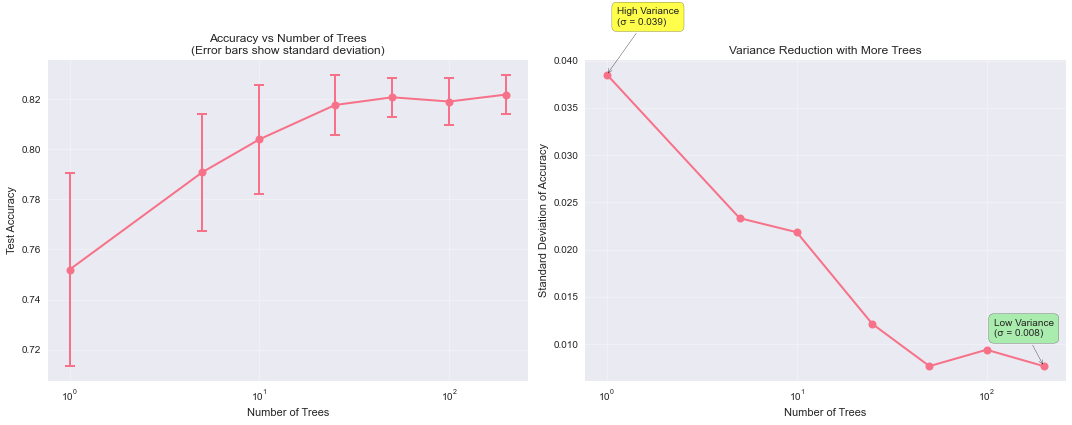

Interpretation:
1. As we add more trees, accuracy stabilizes at a higher level
2. Variance (unpredictability) decreases significantly
3. Diminishing returns: Most improvement comes from first 50-100 trees


In [6]:
# Visualize variance reduction
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Accuracy vs Number of Trees
ax1 = axes[0]
ax1.errorbar(results_df['n_trees'], results_df['mean_accuracy'], 
             yerr=results_df['std_accuracy'], 
             marker='o', capsize=5, capthick=2, linewidth=2, markersize=8)
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Accuracy vs Number of Trees\n(Error bars show standard deviation)')
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

# Plot 2: Variance Reduction
ax2 = axes[1]
ax2.plot(results_df['n_trees'], results_df['std_accuracy'], 'o-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Trees')
ax2.set_ylabel('Standard Deviation of Accuracy')
ax2.set_title('Variance Reduction with More Trees')
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')

# Add annotations
ax2.annotate(f'High Variance\n(σ = {results_df.iloc[0]["std_accuracy"]:.3f})', 
             xy=(results_df.iloc[0]['n_trees'], results_df.iloc[0]['std_accuracy']),
             xytext=(10, 50), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ax2.annotate(f'Low Variance\n(σ = {results_df.iloc[-1]["std_accuracy"]:.3f})', 
             xy=(results_df.iloc[-1]['n_trees'], results_df.iloc[-1]['std_accuracy']),
             xytext=(-50, 30), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

print("Interpretation:")
print("1. As we add more trees, accuracy stabilizes at a higher level")
print("2. Variance (unpredictability) decreases significantly")
print("3. Diminishing returns: Most improvement comes from first 50-100 trees")

## 4. Feature Importance in Random Forest

Random Forest provides excellent **feature importance** measurements:

### How it works:

1. **For each tree**: Calculate how much each feature decreases impurity when used for splitting
2. **Average across all trees**: Get mean importance for each feature
3. **Normalize**: Make importances sum to 1

### Advantages over single tree importance:

- **More stable**: Less sensitive to outliers and noise
- **More reliable**: Based on many trees, not just one
- **Less biased**: Feature randomness reduces bias toward certain features

### Types of Feature Importance:

1. **Impurity-based** (default): Based on decrease in node impurity
2. **Permutation-based**: Based on decrease in accuracy when feature is shuffled

In [7]:
# Analyze feature importance
print("=== FEATURE IMPORTANCE ANALYSIS ===")
print()

# Train a Random Forest with more trees for stable importance estimates
rf_importance = RandomForestClassifier(
    n_estimators=500,
    max_features='sqrt',
    random_state=42
)
rf_importance.fit(X_train, y_train)

# Get feature importances
feature_importance = rf_importance.feature_importances_
feature_std = np.std([tree.feature_importances_ for tree in rf_importance.estimators_], axis=0)

# Create importance DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance,
    'Std': feature_std
}).sort_values('Importance', ascending=False)

print("Feature Importance Ranking:")
print("Rank | Feature           | Importance | Std Dev")
print("-" * 50)
for i, (_, row) in enumerate(importance_df.iterrows(), 1):
    print(f"{i:2d}   | {row['Feature']:<15} | {row['Importance']:.4f}     | {row['Std']:.4f}")

print()
print(f"Top 3 features account for {importance_df.head(3)['Importance'].sum():.1%} of total importance")
print(f"All features with importance > 0.05: {(importance_df['Importance'] > 0.05).sum()} features")

=== FEATURE IMPORTANCE ANALYSIS ===

Feature Importance Ranking:
Rank | Feature           | Importance | Std Dev
--------------------------------------------------
 1   | Fare            | 0.2674     | 0.0542
 2   | Age             | 0.2294     | 0.0365
 3   | Sex             | 0.1933     | 0.1048
 4   | Title           | 0.1093     | 0.0893
 5   | Pclass          | 0.0855     | 0.0379
 6   | FamilySize      | 0.0672     | 0.0286
 7   | Embarked        | 0.0330     | 0.0132
 8   | IsAlone         | 0.0148     | 0.0161

Top 3 features account for 69.0% of total importance
All features with importance > 0.05: 6 features


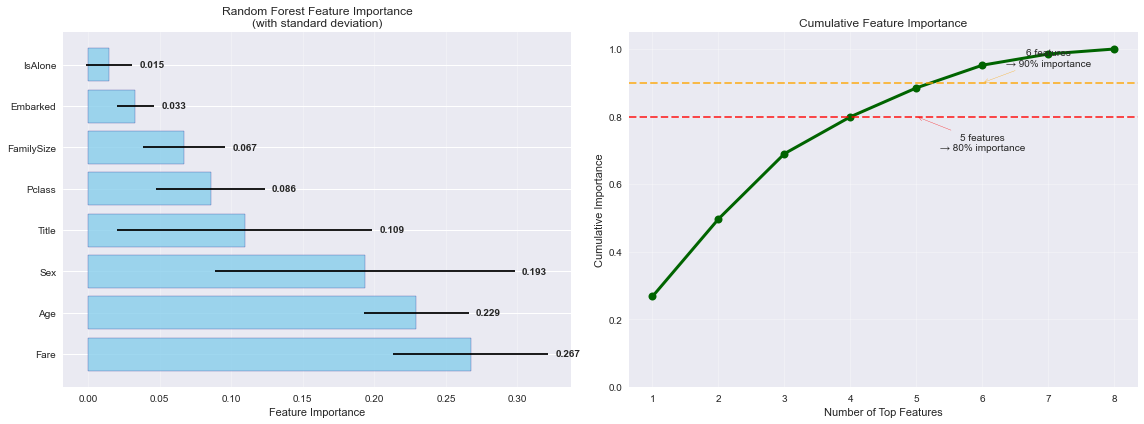

Feature Selection Insights:
  5 features capture 80% of importance
  6 features capture 90% of importance
  Could potentially reduce from 8 to 5 features


In [8]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Bar chart with error bars
ax1 = axes[0]
y_pos = range(len(importance_df))
bars = ax1.barh(y_pos, importance_df['Importance'], xerr=importance_df['Std'], 
                capsize=3, alpha=0.8, color='skyblue', edgecolor='navy')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(importance_df['Feature'])
ax1.set_xlabel('Feature Importance')
ax1.set_title('Random Forest Feature Importance\n(with standard deviation)')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, importance) in enumerate(zip(bars, importance_df['Importance'])):
    width = bar.get_width()
    ax1.text(width + importance_df.iloc[i]['Std'] + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{importance:.3f}', ha='left', va='center', fontsize=10, fontweight='bold')

# Plot 2: Cumulative importance
ax2 = axes[1]
cumulative_importance = np.cumsum(importance_df['Importance'])
ax2.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 
         'o-', linewidth=3, markersize=8, color='darkgreen')
ax2.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, linewidth=2)
ax2.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, linewidth=2)
ax2.set_xlabel('Number of Top Features')
ax2.set_ylabel('Cumulative Importance')
ax2.set_title('Cumulative Feature Importance')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1.05)

# Add annotations
features_80 = np.argmax(cumulative_importance >= 0.8) + 1
features_90 = np.argmax(cumulative_importance >= 0.9) + 1
ax2.annotate(f'{features_80} features\n→ 80% importance', 
             xy=(features_80, 0.8), xytext=(features_80 + 1, 0.7),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=10, ha='center')
ax2.annotate(f'{features_90} features\n→ 90% importance', 
             xy=(features_90, 0.9), xytext=(features_90 + 1, 0.95),
             arrowprops=dict(arrowstyle='->', color='orange'),
             fontsize=10, ha='center')

plt.tight_layout()
plt.show()

print(f"Feature Selection Insights:")
print(f"  {features_80} features capture 80% of importance")
print(f"  {features_90} features capture 90% of importance")
print(f"  Could potentially reduce from {len(feature_names)} to {features_80} features")

=== IMPURITY vs PERMUTATION IMPORTANCE ===

Comparison of Importance Methods:
Feature           | Impurity | Permutation | Diff
-------------------------------------------------------
Fare            | 0.2674   | 0.0553      | -0.2121
Age             | 0.2294   | 0.0620      | -0.1674
Sex             | 0.1933   | 0.1296      | -0.0637
Title           | 0.1093   | 0.0872      | -0.0221
Pclass          | 0.0855   | 0.0564      | -0.0291
FamilySize      | 0.0672   | 0.0218      | -0.0454
Embarked        | 0.0330   | 0.0117      | -0.0213
IsAlone         | 0.0148   | -0.0084      | -0.0232


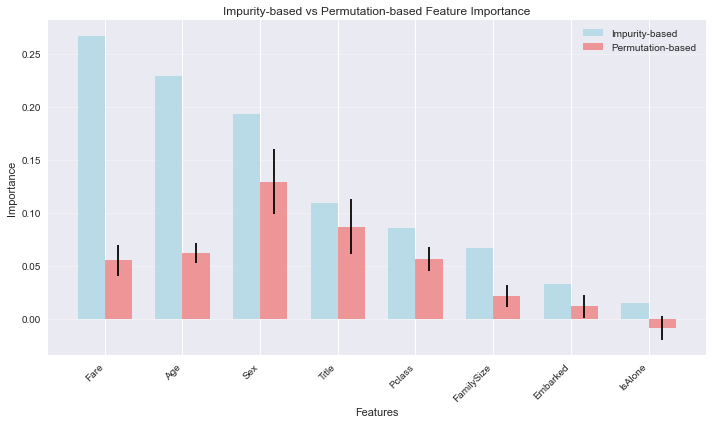


Key Differences:
  Impurity-based: Fast, but can be biased toward high-cardinality features
  Permutation-based: Slower, but shows actual predictive importance


In [9]:
# Compare impurity-based vs permutation importance
print("=== IMPURITY vs PERMUTATION IMPORTANCE ===")
print()

from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(
    rf_importance, X_test, y_test, 
    n_repeats=10, random_state=42, scoring='accuracy'
)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Feature': feature_names,
    'Impurity_Importance': rf_importance.feature_importances_,
    'Permutation_Importance': perm_importance.importances_mean,
    'Perm_Std': perm_importance.importances_std
}).sort_values('Impurity_Importance', ascending=False)

print("Comparison of Importance Methods:")
print("Feature           | Impurity | Permutation | Diff")
print("-" * 55)
for _, row in comparison_df.iterrows():
    diff = row['Permutation_Importance'] - row['Impurity_Importance']
    print(f"{row['Feature']:<15} | {row['Impurity_Importance']:.4f}   | {row['Permutation_Importance']:.4f}      | {diff:+.4f}")

# Visualize comparison
plt.figure(figsize=(10, 6))
x = range(len(comparison_df))
width = 0.35

plt.bar([i - width/2 for i in x], comparison_df['Impurity_Importance'], 
        width, label='Impurity-based', alpha=0.8, color='lightblue')
plt.bar([i + width/2 for i in x], comparison_df['Permutation_Importance'], 
        width, label='Permutation-based', alpha=0.8, color='lightcoral',
        yerr=comparison_df['Perm_Std'], capsize=3)

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Impurity-based vs Permutation-based Feature Importance')
plt.xticks(x, comparison_df['Feature'], rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print()
print("Key Differences:")
print("  Impurity-based: Fast, but can be biased toward high-cardinality features")
print("  Permutation-based: Slower, but shows actual predictive importance")

## 5. Hyperparameter Tuning

Random Forest has several important hyperparameters:

### Key Hyperparameters:

1. **n_estimators**: Number of trees
   - More trees = better performance (up to a point)
   - Typical range: 100-1000

2. **max_features**: Features to consider per split
   - 'sqrt': √(n_features) - good default
   - 'log2': log₂(n_features) - alternative
   - integer: specific number

3. **max_depth**: Maximum tree depth
   - None: unlimited (default)
   - integer: limit depth to prevent overfitting

4. **min_samples_split**: Minimum samples to split a node
   - Higher values prevent overfitting
   - Default: 2

5. **min_samples_leaf**: Minimum samples in leaf node
   - Higher values smooth the model
   - Default: 1

6. **bootstrap**: Whether to use bootstrap sampling
   - True: Standard Random Forest
   - False: Use entire dataset for each tree

In [10]:
# Demonstrate hyperparameter effects
print("=== HYPERPARAMETER EFFECTS ANALYSIS ===")
print()

# Test different numbers of estimators
n_estimators_range = [10, 25, 50, 100, 200, 500]
estimator_results = []

print("Effect of Number of Estimators:")
for n_est in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n_est, random_state=42)
    rf.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, rf.predict(X_train))
    test_acc = accuracy_score(y_test, rf.predict(X_test))
    
    estimator_results.append({
        'n_estimators': n_est,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'overfitting': train_acc - test_acc
    })
    
    print(f"  {n_est:3d} trees: Train={train_acc:.3f}, Test={test_acc:.3f}, Gap={train_acc-test_acc:.3f}")

print()

# Test different max_features
max_features_options = ['sqrt', 'log2', 0.5, 0.8, None]
features_results = []

print("Effect of max_features:")
for max_feat in max_features_options:
    rf = RandomForestClassifier(n_estimators=100, max_features=max_feat, random_state=42)
    rf.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, rf.predict(X_train))
    test_acc = accuracy_score(y_test, rf.predict(X_test))
    
    features_results.append({
        'max_features': str(max_feat),
        'train_acc': train_acc,
        'test_acc': test_acc,
        'overfitting': train_acc - test_acc
    })
    
    actual_max_feat = rf.max_features_ if hasattr(rf, 'max_features_') else 'N/A'
    print(f"  {str(max_feat):<6}: Train={train_acc:.3f}, Test={test_acc:.3f}, Gap={train_acc-test_acc:.3f} (actual: {actual_max_feat})")

print()

# Test effect of tree depth
max_depth_options = [3, 5, 10, 20, None]
depth_results = []

print("Effect of max_depth:")
for max_dep in max_depth_options:
    rf = RandomForestClassifier(n_estimators=100, max_depth=max_dep, random_state=42)
    rf.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, rf.predict(X_train))
    test_acc = accuracy_score(y_test, rf.predict(X_test))
    
    depth_results.append({
        'max_depth': str(max_dep),
        'train_acc': train_acc,
        'test_acc': test_acc,
        'overfitting': train_acc - test_acc
    })
    
    print(f"  {str(max_dep):<6}: Train={train_acc:.3f}, Test={test_acc:.3f}, Gap={train_acc-test_acc:.3f}")

=== HYPERPARAMETER EFFECTS ANALYSIS ===

Effect of Number of Estimators:
   10 trees: Train=0.968, Test=0.804, Gap=0.163
   25 trees: Train=0.983, Test=0.821, Gap=0.162
   50 trees: Train=0.983, Test=0.821, Gap=0.162
  100 trees: Train=0.983, Test=0.827, Gap=0.156
  200 trees: Train=0.983, Test=0.832, Gap=0.151
  500 trees: Train=0.983, Test=0.832, Gap=0.151

Effect of max_features:
  sqrt  : Train=0.983, Test=0.827, Gap=0.156 (actual: N/A)
  log2  : Train=0.983, Test=0.832, Gap=0.151 (actual: N/A)
  0.5   : Train=0.983, Test=0.827, Gap=0.156 (actual: N/A)
  0.8   : Train=0.983, Test=0.827, Gap=0.156 (actual: N/A)
  None  : Train=0.983, Test=0.821, Gap=0.162 (actual: N/A)

Effect of max_depth:
  3     : Train=0.830, Test=0.810, Gap=0.020
  5     : Train=0.848, Test=0.821, Gap=0.027
  10    : Train=0.956, Test=0.816, Gap=0.141
  20    : Train=0.983, Test=0.821, Gap=0.162
  None  : Train=0.983, Test=0.827, Gap=0.156


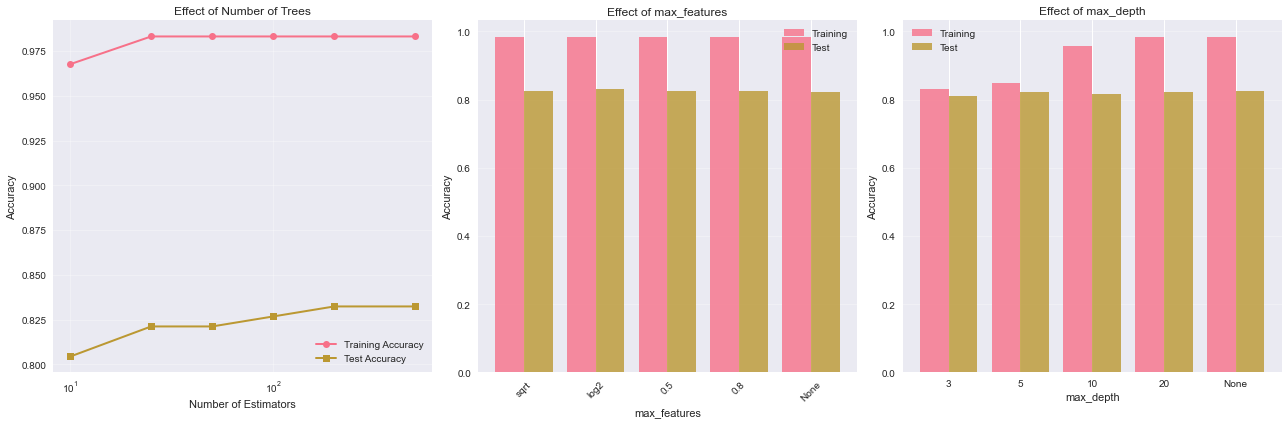

Key Insights:
1. More trees generally improve performance (diminishing returns after ~100)
2. sqrt(n_features) is usually optimal for max_features
3. Unlimited depth works well for Random Forest (less overfitting than single trees)


In [11]:
# Visualize hyperparameter effects
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Number of Estimators
ax1 = axes[0]
est_df = pd.DataFrame(estimator_results)
ax1.plot(est_df['n_estimators'], est_df['train_acc'], 'o-', label='Training Accuracy', linewidth=2)
ax1.plot(est_df['n_estimators'], est_df['test_acc'], 's-', label='Test Accuracy', linewidth=2)
ax1.set_xlabel('Number of Estimators')
ax1.set_ylabel('Accuracy')
ax1.set_title('Effect of Number of Trees')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

# Plot 2: Max Features
ax2 = axes[1]
feat_df = pd.DataFrame(features_results)
x_pos = range(len(feat_df))
ax2.bar([x - 0.2 for x in x_pos], feat_df['train_acc'], 0.4, label='Training', alpha=0.8)
ax2.bar([x + 0.2 for x in x_pos], feat_df['test_acc'], 0.4, label='Test', alpha=0.8)
ax2.set_xlabel('max_features')
ax2.set_ylabel('Accuracy')
ax2.set_title('Effect of max_features')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(feat_df['max_features'], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Max Depth
ax3 = axes[2]
depth_df = pd.DataFrame(depth_results)
x_pos = range(len(depth_df))
ax3.bar([x - 0.2 for x in x_pos], depth_df['train_acc'], 0.4, label='Training', alpha=0.8)
ax3.bar([x + 0.2 for x in x_pos], depth_df['test_acc'], 0.4, label='Test', alpha=0.8)
ax3.set_xlabel('max_depth')
ax3.set_ylabel('Accuracy')
ax3.set_title('Effect of max_depth')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(depth_df['max_depth'])
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Key Insights:")
print("1. More trees generally improve performance (diminishing returns after ~100)")
print("2. sqrt(n_features) is usually optimal for max_features")
print("3. Unlimited depth works well for Random Forest (less overfitting than single trees)")

## 6. Out-of-Bag (OOB) Error

Random Forest has a built-in validation mechanism: **Out-of-Bag Error**

### How OOB Works:

1. **Bootstrap Sampling**: Each tree uses ~63% of training data
2. **OOB Samples**: Remaining ~37% are "out-of-bag" for that tree
3. **OOB Prediction**: For each sample, use only trees that didn't see it during training
4. **OOB Error**: Calculate error on these OOB predictions

### Benefits:

- **No separate validation set needed**
- **Unbiased estimate** of generalization error
- **Free cross-validation** during training
- **Can monitor overfitting** as you add trees

In [12]:
# Demonstrate Out-of-Bag error
print("=== OUT-OF-BAG ERROR DEMONSTRATION ===")
print()

# Train Random Forest with OOB scoring enabled
rf_oob = RandomForestClassifier(
    n_estimators=200,
    oob_score=True,  # Enable OOB scoring
    random_state=42
)

rf_oob.fit(X_train, y_train)

# Compare OOB score with test score
oob_accuracy = rf_oob.oob_score_
test_accuracy = accuracy_score(y_test, rf_oob.predict(X_test))
train_accuracy = accuracy_score(y_train, rf_oob.predict(X_train))

print(f"Performance Comparison:")
print(f"  Training Accuracy: {train_accuracy:.3f}")
print(f"  OOB Accuracy:      {oob_accuracy:.3f}")
print(f"  Test Accuracy:     {test_accuracy:.3f}")
print()
print(f"OOB vs Test difference: {abs(oob_accuracy - test_accuracy):.3f}")
print()
print("Key Insight: OOB score closely approximates test performance!")
print("This means we can estimate generalization without a separate validation set.")

# Show OOB predictions for some samples
oob_predictions = rf_oob.oob_decision_function_
print(f"\nOOB predictions shape: {oob_predictions.shape}")
print(f"(Each row is a training sample, each column is a class probability)")

# Show examples
print("\nSample OOB predictions:")
print("Sample | True | OOB Prob[Died] | OOB Prob[Survived] | OOB Prediction")
print("-" * 70)
for i in range(5):
    true_label = y_train.iloc[i]
    oob_pred_probs = oob_predictions[i]
    oob_pred = np.argmax(oob_pred_probs)
    print(f"{i:4d}   | {true_label:2d}   | {oob_pred_probs[0]:11.3f} | {oob_pred_probs[1]:14.3f} | {oob_pred:11d}")

=== OUT-OF-BAG ERROR DEMONSTRATION ===

Performance Comparison:
  Training Accuracy: 0.983
  OOB Accuracy:      0.806
  Test Accuracy:     0.832

OOB vs Test difference: 0.026

Key Insight: OOB score closely approximates test performance!
This means we can estimate generalization without a separate validation set.

OOB predictions shape: (712, 2)
(Each row is a training sample, each column is a class probability)

Sample OOB predictions:
Sample | True | OOB Prob[Died] | OOB Prob[Survived] | OOB Prediction
----------------------------------------------------------------------


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
# Compare OOB error with cross-validation
print("=== OOB ERROR vs CROSS-VALIDATION ===")
print()

# Test different numbers of estimators
n_estimators_list = [10, 25, 50, 100, 200, 500]
oob_scores = []
cv_scores_mean = []
cv_scores_std = []

print("Comparison of OOB Error vs Cross-Validation:")
print("Trees | OOB Score | CV Score (5-fold)")
print("-" * 40)

for n_est in n_estimators_list:
    # OOB Score
    rf = RandomForestClassifier(n_estimators=n_est, oob_score=True, random_state=42)
    rf.fit(X_train, y_train)
    oob_score = rf.oob_score_
    
    # Cross-validation Score  
    rf_cv = RandomForestClassifier(n_estimators=n_est, random_state=42)
    cv_scores = cross_val_score(rf_cv, X_train, y_train, cv=5)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    oob_scores.append(oob_score)
    cv_scores_mean.append(cv_mean)
    cv_scores_std.append(cv_std)
    
    print(f"{n_est:3d}   | {oob_score:.3f}     | {cv_mean:.3f} (+/- {cv_std*2:.3f})")

# Visualize comparison
plt.figure(figsize=(10, 6))
plt.errorbar(n_estimators_list, cv_scores_mean, yerr=cv_scores_std, 
             label='5-Fold Cross-Validation', marker='o', capsize=5, linewidth=2)
plt.plot(n_estimators_list, oob_scores, 'o-', 
         label='Out-of-Bag Score', linewidth=2, markersize=8)
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy Score')
plt.title('OOB Score vs Cross-Validation Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.tight_layout()
plt.show()

# Calculate correlation
correlation = np.corrcoef(oob_scores, cv_scores_mean)[0, 1]
print(f"\nCorrelation between OOB and CV scores: {correlation:.3f}")
print(f"Mean absolute difference: {np.mean(np.abs(np.array(oob_scores) - np.array(cv_scores_mean))):.3f}")
print()
print("Conclusion: OOB score provides a reliable estimate of model performance")
print("without the computational cost of cross-validation!")

## 7. Advantages and Limitations

### ✅ Advantages

1. **Excellent Performance**: Often achieves high accuracy out-of-the-box
2. **Overfitting Resistance**: Much less prone to overfitting than single trees
3. **Feature Importance**: Provides reliable feature importance estimates
4. **Handles Missing Values**: Can handle missing data (with modifications)
5. **No Feature Scaling**: Works with features on different scales
6. **Parallel Training**: Trees can be trained in parallel
7. **OOB Validation**: Built-in validation without separate test set
8. **Robust to Outliers**: Ensemble averaging reduces outlier impact
9. **Works with Mixed Data**: Handles both numerical and categorical features
10. **Good Default Parameters**: Often works well without much tuning

### ❌ Limitations

1. **Memory Usage**: Requires more memory than single models
2. **Prediction Speed**: Slower prediction than single models
3. **Less Interpretable**: Harder to interpret than single decision trees
4. **Biased to Majority Class**: Can be biased in imbalanced datasets
5. **Overfitting with Noise**: Can still overfit with very noisy data
6. **Feature Correlation**: Performance degrades with highly correlated features
7. **Linear Relationships**: Not optimal for purely linear relationships
8. **Extrapolation**: Cannot extrapolate beyond training data range

In [ ]:
# Final comprehensive evaluation
print("=== COMPREHENSIVE RANDOM FOREST EVALUATION ===")
print()

# Create optimized Random Forest
final_rf = RandomForestClassifier(
    n_estimators=300,
    max_features='sqrt',
    min_samples_split=5,
    min_samples_leaf=2,
    oob_score=True,
    random_state=42,
    n_jobs=-1  # Use all cores
)

final_rf.fit(X_train, y_train)

# Comprehensive evaluation
evaluator = ModelEvaluator("Optimized Random Forest")
y_pred_final = final_rf.predict(X_test)
y_proba_final = final_rf.predict_proba(X_test)

metrics = evaluator.evaluate_classification(
    y_test, y_pred_final, y_proba_final,
    class_names=['Died', 'Survived']
)

evaluator.print_detailed_report()

print(f"\nAdditional Random Forest Metrics:")
print(f"  OOB Score: {final_rf.oob_score_:.3f}")
print(f"  Number of Trees: {final_rf.n_estimators}")
print(f"  Max Features per Split: {final_rf.max_features}")

# Individual tree performance analysis
print(f"\nIndividual Tree Analysis:")
individual_accuracies = []
for i, tree in enumerate(final_rf.estimators_[:10]):  # Check first 10 trees
    tree_pred = tree.predict(X_test)
    tree_acc = accuracy_score(y_test, tree_pred)
    individual_accuracies.append(tree_acc)
    if i < 5:  # Print first 5
        print(f"  Tree {i+1}: {tree_acc:.3f} accuracy")

print(f"  Average single tree accuracy: {np.mean(individual_accuracies):.3f}")
print(f"  Random Forest accuracy: {metrics['accuracy']:.3f}")
print(f"  Ensemble improvement: {metrics['accuracy'] - np.mean(individual_accuracies):+.3f}")

# Memory and timing info
import sys
model_size = sys.getsizeof(final_rf) / (1024 * 1024)  # MB
print(f"\nModel Statistics:")
print(f"  Model size: {model_size:.2f} MB")
print(f"  Total nodes: {sum(tree.tree_.node_count for tree in final_rf.estimators_)}")
print(f"  Average tree depth: {np.mean([tree.tree_.max_depth for tree in final_rf.estimators_]):.1f}")

## 8. Summary and Key Takeaways

### 🎯 What You've Learned

1. **Ensemble Power**: Multiple weak learners create a strong learner
2. **Two-Fold Randomness**: Bootstrap sampling + feature randomness
3. **Bias-Variance Tradeoff**: How averaging reduces variance while maintaining low bias
4. **Feature Importance**: Reliable importance estimates from ensemble averaging
5. **OOB Error**: Built-in validation mechanism
6. **Hyperparameter Effects**: How different parameters affect performance
7. **Practical Implementation**: Real-world application and evaluation

### 🚀 Next Steps

1. **Advanced Ensembles**: Learn Gradient Boosting and XGBoost
2. **Feature Engineering**: Create better features for tree-based models
3. **Hyperparameter Optimization**: Use RandomizedSearchCV or Bayesian optimization
4. **Imbalanced Data**: Learn techniques for handling class imbalance
5. **Interpretability**: Explore SHAP values and partial dependence plots

### 💡 Key Insights

- **Wisdom of Crowds**: Individual errors cancel out in ensemble averaging
- **Randomness is Key**: Bootstrap + feature randomness creates diversity
- **Less Overfitting**: Ensembles are more robust than individual models
- **Feature Importance**: More reliable than single tree importance
- **Good Defaults**: Often works well with minimal tuning
- **OOB Validation**: Free performance estimation during training

### 🛠️ Best Practices

1. **Start with Defaults**: 100 trees, sqrt(features), unlimited depth
2. **Use OOB Score**: Monitor performance without validation set
3. **Check Feature Importance**: Understand what drives predictions
4. **Consider Memory**: More trees = more memory usage
5. **Parallel Training**: Use n_jobs=-1 for faster training
6. **Feature Selection**: Remove low-importance features if needed

---

**Congratulations!** You now understand Random Forest, one of the most powerful and widely-used machine learning algorithms. Random Forest demonstrates the power of ensemble learning and serves as an excellent foundation for understanding more advanced ensemble methods.

Remember: Sometimes the best approach is to combine many simple models rather than building one complex model! 🌲